In [ ]:
from model import load_as_trt_model
from rchess import Board, Move
from utils import FakeTRTFunc
import numpy as np
from configs import engineplayConfig, selfplayConfig
from mcts import MCTS, debug_search, Node

use_fake = False
if use_fake:
    trt_func = FakeTRTFunc()
else:
    trt_func, _ = load_as_trt_model("latest")


2025-05-13 12:29:42.817993: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [2]:
mctsSearch = MCTS(engineplayConfig)
#mctsSearch = MCTS(selfplayConfig)

In [3]:
from chess import Board as PyBoard
board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
#board = Board("6k1/8/8/3P4/8/8/8/K7 b - - 0 1")
#board = Board("2k5/5pn1/4P3/8/5Kn1/8/3R4/8 b - - 0 56")
pyBoard = PyBoard(board.fen())
#print(board)

In [68]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 0, 1.5, True)
debug_search(board, root, 3, 10)
board.push_num(move)
move_uci = Move(move).uci()
pyBoard.push_uci(move_uci)


  +---+---+---+---+---+---+---+---+
  |   | Q |   |   |   |   |   |   | 8
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | k | p |   |   | 7
  +---+---+---+---+---+---+---+---+
  | p |   |   |   |   |   | p |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   | p |   |   | P | P |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   | N |   |   | K |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | P |   |   |   |   |   |   | 2
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: 1Q6/4kp2/p5p1/8/2p2PP1/2N2K2/PP6/8 w - - 1 17
Key: d336a7397ef0dd0b
Elapsed time: 1.50s
Total visits: 13037
--------------------------------------------------------------------------------------------------------------
PV:
1. 0.988777 | f4f5 g6f5 f3g3 f7f6 g3f3 e7e6 f3e2
2. 0.984925 | f3f2 e7d7 f2g2 d7c6 g2f3 f7f5 f3e2
3. 0.98501

Move.from_uci('f4f5')

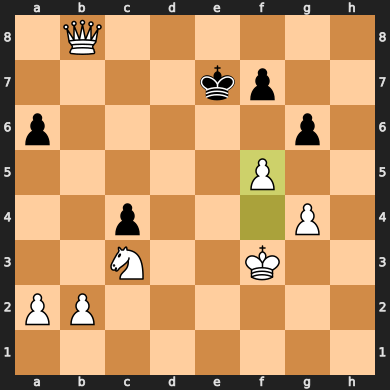

In [69]:
pyBoard

In [29]:
from model import predict_fn
board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
image, hash = board.history(engineplayConfig["history_perspective_flip"])
value, policies = predict_fn(trt_func, np.array([image]))
print("Value:", value.numpy())
print("Policies:", policies.numpy())
# Max of policies and min of policies
policies = policies.numpy()[0]
print("Max policy:", np.max(policies))
print("Min policy:", np.min(policies))
print("Mean policy:", np.mean(policies))

Value: [[0.00239372]]
Policies: [[ 0.73828125  0.9121094   0.81933594 ... -0.3786621   0.89160156
   1.0566406 ]]
Max policy: 1.5595703
Min policy: -0.8125
Mean policy: 0.0023056436
